In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, Dense, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, Model
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mig
import numpy as np
import pathlib
np.random.seed(69)

**DEFINING CLASS**

In [2]:
PATH = './PokemonData/'
data_dir = pathlib.Path(PATH)

In [3]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES.shape

(151,)

In [4]:
IDG_train = ImageDataGenerator(rescale = 1./255,
                               validation_split=0.2)

IDG_valid = ImageDataGenerator(rescale = 1./255,
                               validation_split=0.2)

train_data = IDG_train.flow_from_directory(PATH,
                                           target_size=(299, 299),
                                           batch_size=32,
                                           classes = list(CLASS_NAMES),
                                           subset='training',
                                           shuffle=True,
                                           seed=69)

validation_data = IDG_valid.flow_from_directory(PATH,
                                                target_size=(299, 299),
                                                batch_size=32,
                                                classes = list(CLASS_NAMES),
                                                subset='validation',
                                                shuffle=False,
                                                seed=69)

Found 5542 images belonging to 151 classes.
Found 1311 images belonging to 151 classes.


In [5]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n].argmax()])
      plt.axis('off')

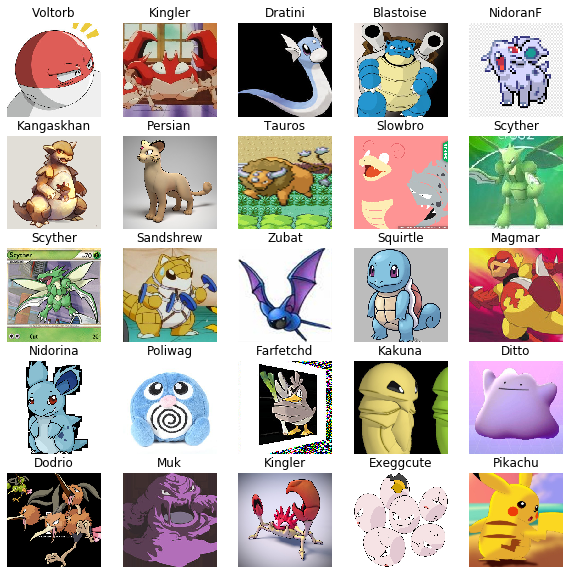

In [6]:
image_batch, label_batch = train_data[0]
show_batch(image_batch, label_batch)

In [7]:
base_model = Xception(weights='imagenet',  # Load weights pre-trained on ImageNet.
                 input_shape=(299, 299, 3),
                 include_top=False)  # Do not include the ImageNet classifier at the top.
base_model.trainable = False
inputs = Input(shape=(299, 299, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = Dense(CLASS_NAMES.shape[0], activation='softmax')(x)
model = Model(inputs, outputs)

In [8]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 151)               309399    
Total params: 21,170,879
Trainable params: 309,399
Non-trainable params: 20,861,480
_________________________________________________________________


In [9]:
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

hist = model.fit(train_data, epochs=50, steps_per_epoch=len(train_data), validation_data=validation_data, validation_steps=len(validation_data))

Epoch 1/50
174/174 [==============================] - 38s 219ms/step - loss: 3.9777 - accuracy: 0.2499 - val_loss: 3.0267 - val_accuracy: 0.4416
Epoch 2/50
174/174 [==============================] - 38s 216ms/step - loss: 2.2378 - accuracy: 0.6483 - val_loss: 2.2564 - val_accuracy: 0.5744
Epoch 3/50
174/174 [==============================] - 38s 217ms/step - loss: 1.5144 - accuracy: 0.7826 - val_loss: 1.9159 - val_accuracy: 0.6354
Epoch 4/50
174/174 [==============================] - 38s 218ms/step - loss: 1.1216 - accuracy: 0.8479 - val_loss: 1.7209 - val_accuracy: 0.6484
Epoch 5/50
174/174 [==============================] - 38s 218ms/step - loss: 0.8675 - accuracy: 0.8952 - val_loss: 1.5828 - val_accuracy: 0.6720
Epoch 6/50
174/174 [==============================] - 38s 219ms/step - loss: 0.6952 - accuracy: 0.9257 - val_loss: 1.5049 - val_accuracy: 0.6812
Epoch 7/50
174/174 [==============================] - 38s 219ms/step - loss: 0.5643 - accuracy: 0.9479 - val_loss: 1.4402 - val_ac

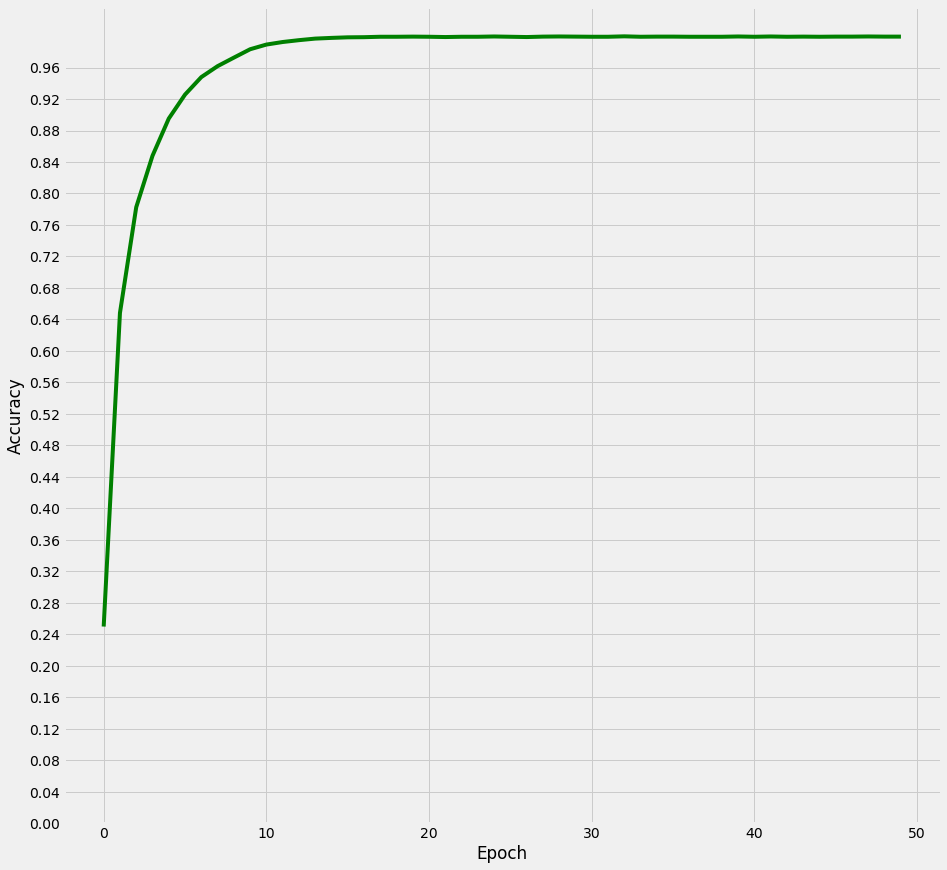

In [10]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(14,14))
plt.plot(hist.history['accuracy'],label='accuracy',color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0, 1, step=0.04))
plt.show()

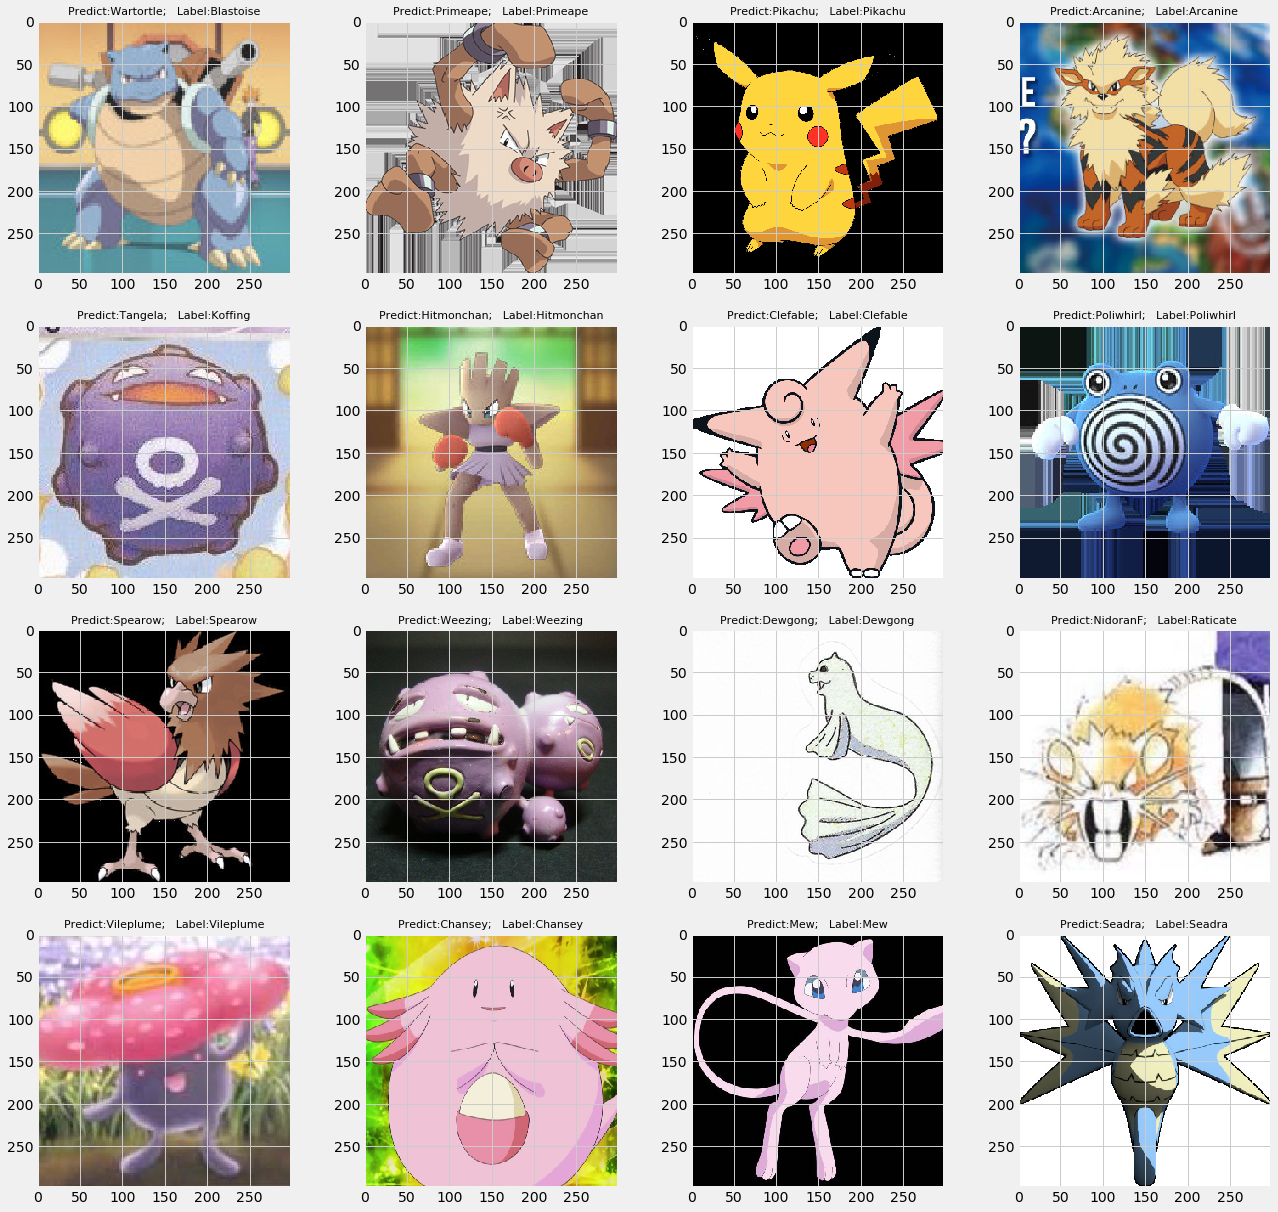

In [11]:
plt.figure(figsize=(20,20))
sam_x = []
sam_y = []
for i in np.random.choice(len(validation_data), size=16, replace=False):
    x, y = validation_data[i]
    sam_x.append(x[0])
    sam_y.append(y[0])
sam_x = np.array(sam_x)
pred_ = model.predict(sam_x)
for i in range(16):
    pred,y = pred_[i].argmax(), sam_y[i].argmax()
    plt.subplot(4,4,i+1)
    plt.imshow(sam_x[i])
    title_ = 'Predict:' + str(CLASS_NAMES[pred])+ ';   Label:' + str(CLASS_NAMES[y])
    plt.title(title_,size=11)
plt.show()

In [14]:
y_true = validation_data.labels
y_pred = model.predict(validation_data).argmax(axis=1)
c = confusion_matrix(y_true, y_pred)

Text(0.5, 1.0, 'Confusion matrix')

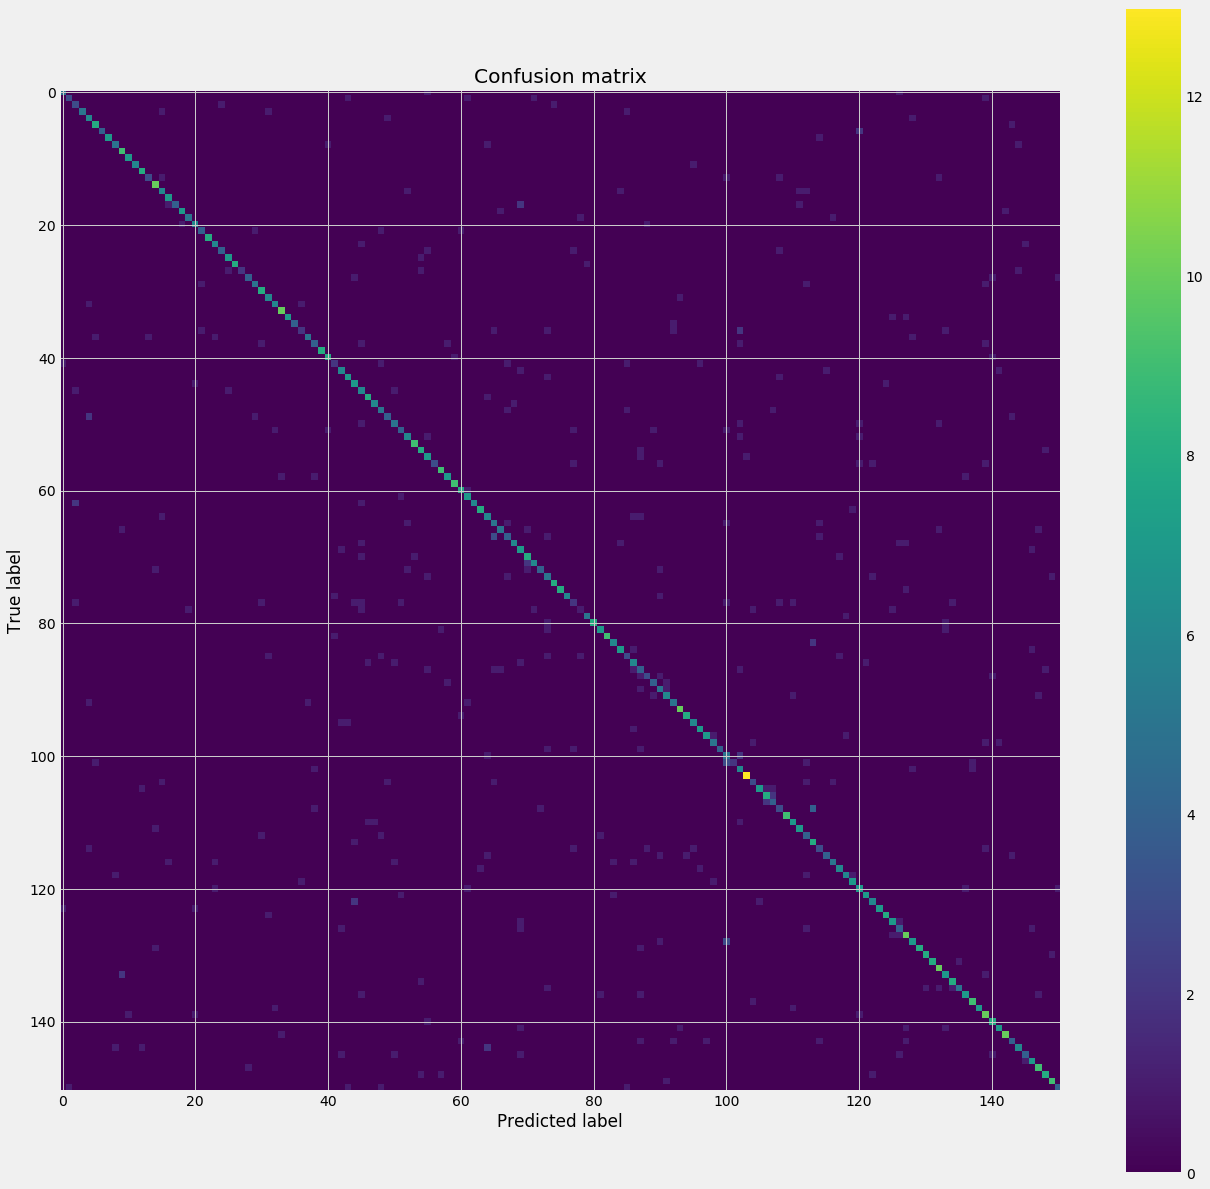

In [15]:
plt.figure(figsize=(20,20))
plt.imshow(c)
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')

Text(0.5, 0, 'Fraction correctly labeled')

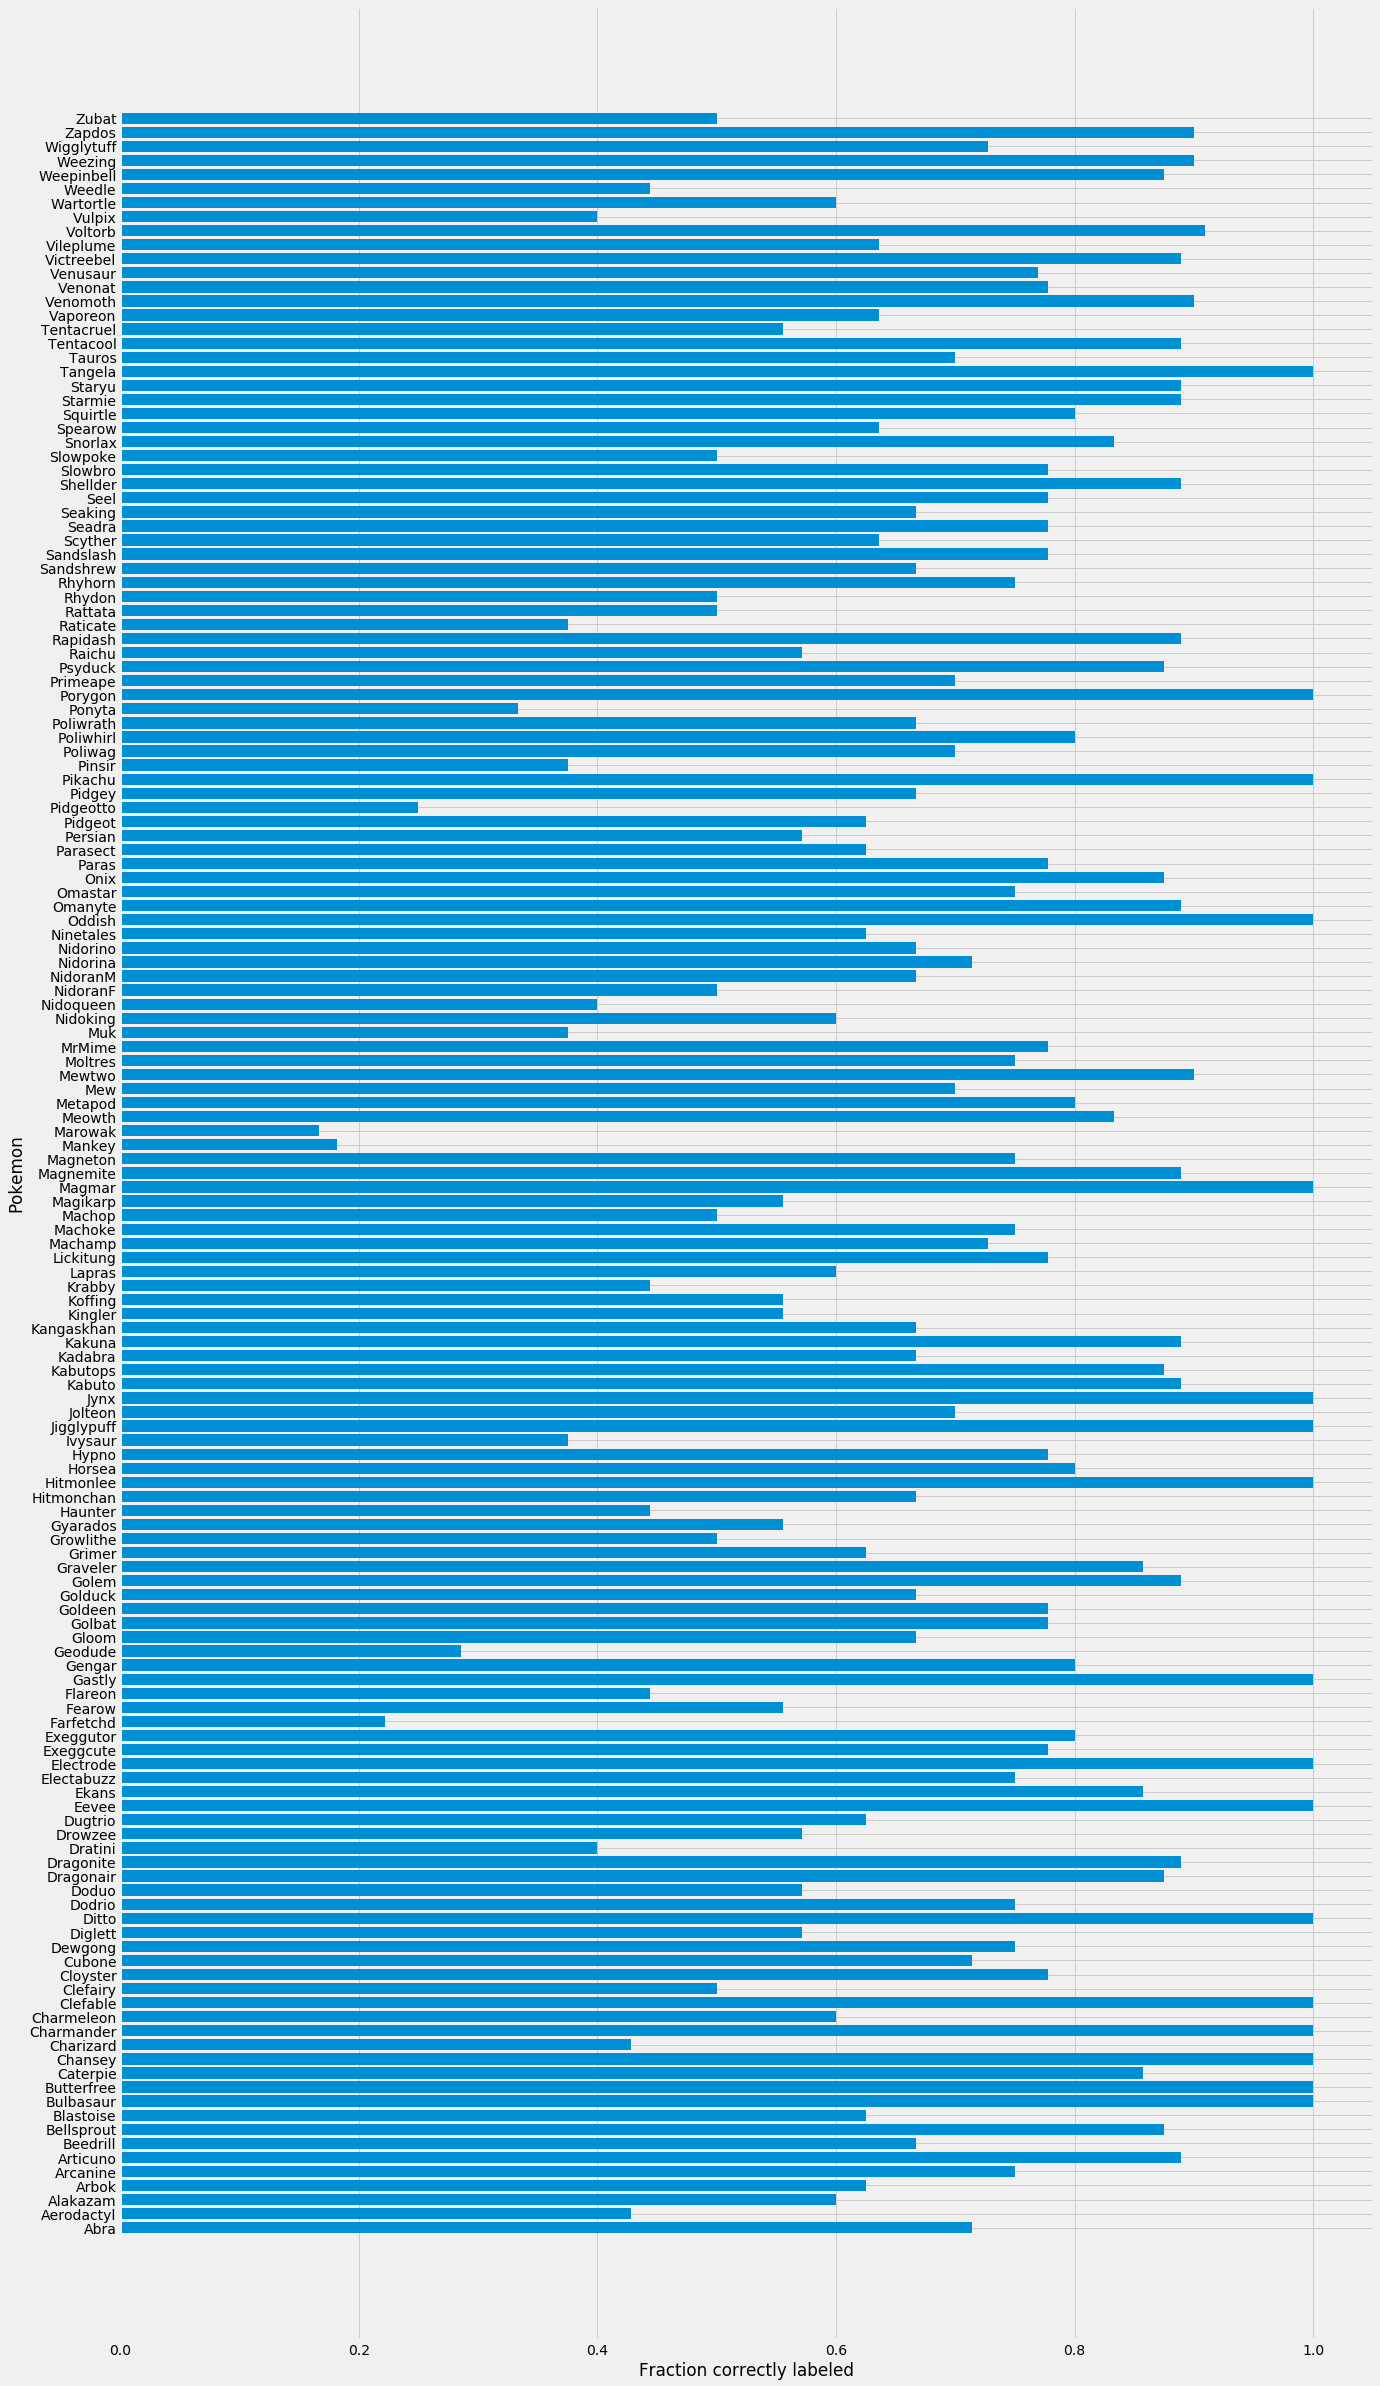

In [16]:
plt.figure(figsize=(20,40))
plt.barh(CLASS_NAMES, c.diagonal() / c.sum(axis=1))
plt.ylabel('Pokemon')
plt.xlabel('Fraction correctly labeled')